In [30]:
pip install nltk==3.5

     ---------------------------------------- 1.4/1.4 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434693 sha256=afa59941c5dad430fb276cf4db8d7856c3061a5fdbee96015db40fd72d911bdb
  Stored in directory: c:\users\moidhassan\appdata\local\pip\cache\wheels\45\6c\46\a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca, get_dict
import w4_unittest as w4_unittest

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moidhassan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
nltk.__version__

'3.5'

In [3]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [4]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('./data/shakespeare_passage.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [5]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5778
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


In [6]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5778


In [7]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2745
Word which has index 2743:   kindness


### Training the model

In [8]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C1 GRADED FUNCTION: initialize_model
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    ### END CODE HERE ###
    return W1, W2, b1, b2

In [9]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [10]:
# Test your function
w4_unittest.test_initialize_model(initialize_model)

 All tests passed


In [11]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C2 GRADED FUNCTION: softmax
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate yhat (softmax)
    yhat = np.exp(z) / (np.sum(np.exp(z),axis=0))
    ### END CODE HERE ###
    return yhat

In [12]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [13]:
# Test your function
w4_unittest.test_softmax(softmax)

 All tests passed


In [14]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C3 GRADED FUNCTION: forward_prop
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    ### START CODE HERE (Replace instances of 'None' with your own code) ###
    # Calculate h
    h = np.dot(W1,x) + b1

    # Apply the relu on h, 
    # store the relu in h
    h = np.maximum(0,h)

    # Calculate z
    z = np.dot(W2,h) + b2

    ### END CODE HERE ###

    return z, h

In [15]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
#print(tmp_x)
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [16]:
# Test your function
w4_unittest.test_forward_prop(forward_prop)

 All tests passed


### Cost Function

In [17]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [18]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 8.9542


### Training the Model - Backpropagation

In [19]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C4 GRADED FUNCTION: back_prop
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    ### START CODE HERE (Replace instanes of 'None' with your code) ###
    # Compute l1 as W2^T (Yhat - Y)
    # and re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T, yhat-y)

    # Apply relu to l1
    l1 = np.maximum(0,l1)

    # compute the gradient for W1
    grad_W1 = (1/batch_size)*np.dot(l1, x.T)

    # Compute gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    
    # compute gradient for b1
    grad_b1 = (1/batch_size)*np.dot(l1, np.ones((batch_size,1)))

    # compute gradient for b2
    grad_b2 = (1/batch_size)*np.dot(yhat - y, np.ones((batch_size,1)))
    ### END CODE HERE ####
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [20]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)


In [21]:
# Test your function
w4_unittest.test_back_prop(back_prop)

 All tests passed


In [22]:
# UNIT TEST COMMENT: Candidate for Table Driven Tests
# UNQ_C5 GRADED FUNCTION: gradient_descent
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 128
#    batch_size = 512
    iters = 0
    C = 2 
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###                
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # update weights and biases
        W1 = W1 - alpha*grad_W1
        W2 = W2 - alpha*grad_W2
        b1 = b1 - alpha*grad_b1
        b2 = b2 - alpha*grad_b2

        ### END CODE HERE ###
        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [23]:
# test your function
# UNIT TEST COMMENT: Each time this cell is run the cost for each iteration changes slightly (the change is less dramatic after some iterations)
# to have this into account let's accept an answer as correct if the cost of iter 15 = 41.6 (without caring about decimal points beyond the first decimal)
# 41.66, 41.69778, 41.63, etc should all be valid answers.
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 11.714748
iters: 20 cost: 3.788280
iters: 30 cost: 9.179923
iters: 40 cost: 1.747809
iters: 50 cost: 8.706968
iters: 60 cost: 10.182652
iters: 70 cost: 7.258762
iters: 80 cost: 10.214489
iters: 90 cost: 9.311061
iters: 100 cost: 10.103939
iters: 110 cost: 5.582018
iters: 120 cost: 4.330974
iters: 130 cost: 9.436612
iters: 140 cost: 6.875775
iters: 150 cost: 2.874090


In [28]:
# Test your function
w4_unittest.test_gradient_descent(gradient_descent, data, word2Ind, N=10, V=len(word2Ind), num_iters=15)

name default_check
iters: 10 cost: 9.065788
name small_check
iters: 10 cost: 8.649236
 All tests passed


In [25]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2745, 3951, 2961, 3023, 5675, 1452, 5674, 4191, 2316, 4278]


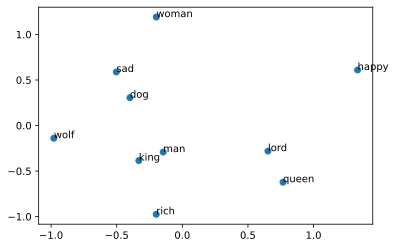

In [26]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

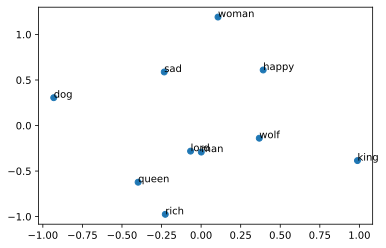

In [27]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()